In [99]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter

In [100]:
path_year = "2023"

* Shapefile Link  
https://www2.census.gov/geo/tiger/

In [101]:
gdf = gpd.read_file("../Shapefiles/tl_" + path_year + "_us_county.shp")
gdf.columns = gdf.columns.str.strip()

#gdf

In [102]:
min_longitude, max_longitude = -150, -50
min_latitude, max_latitude = 20, 50

gdf.loc[:, "INTPTLON"] = gdf["INTPTLON"].astype(float)
gdf.loc[:, "INTPTLAT"] = gdf["INTPTLAT"].astype(float)

gdf = gdf[(gdf["INTPTLON"] >= min_longitude) & 
                   (gdf["INTPTLON"] <= max_longitude) & 
                   (gdf["INTPTLAT"] >= min_latitude) & 
                   (gdf["INTPTLAT"] <= max_latitude)]

gdf.loc[:, "GEOIDFQ"] = "0500000US" + gdf["GEOID"]

gdf = gdf[["GEOIDFQ", "geometry", "ALAND", "AWATER"]]

gdf["ALAND"] = gdf["ALAND"] / 1_000_000
gdf["AWATER"] = gdf["AWATER"] / 1_000_000
gdf = gdf.rename(columns={"ALAND": "Land area (km²)",
                          "AWATER": "Water area (km²)"})

#gdf

* Utility

In [103]:
def print_column(df: pd.DataFrame):
    for col in df.loc[:, ~df.columns.str.contains("Margin of Error!!")]:
        print(col)

def print_dubs(df: pd.DataFrame):
    print(df.columns[df.columns.duplicated() & ~df.columns.str.contains("Margin of Error!!")])

* DP05 : ACS Demographic and Housing Estimates  
https://data.census.gov/table/ACSDP5Y2023.DP05?g=010XX00US$0500000&d=ACS+5-Year+Estimates+Data+Profiles&moe=false  

In [104]:
df_05 = pd.read_csv("../Tables/ACSDP5Y" + path_year + ".DP05-Data.csv", dtype=str)
df_05.columns = df_05.iloc[0]
df_05.columns = df_05.columns.astype(str)
df_05.columns = df_05.columns.str.strip()
df_05 = df_05[1:]

column_counts = Counter()
new_columns = []
for col in df_05.columns:
    new_columns.append(f"{col} {column_counts[col]}")
    column_counts[col] += 1
df_05.columns = new_columns

df_05 = df_05.rename(columns={'Geography 0': 'GEOIDFQ'})
df_05 = pd.merge(gdf["GEOIDFQ"], df_05, left_on="GEOIDFQ", right_on="GEOIDFQ", how="left")

#df_05

In [105]:
df_05_estimate_dict = {
    'Estimate!!SEX AND AGE!!Total population 0': 'Total population',
    'Estimate!!SEX AND AGE!!Total population!!Median age (years) 0': 'Median age',
}

df_05_estimate_sel = list(df_05_estimate_dict.keys())

df_05_estimate = df_05.loc[:, df_05.columns.str.contains("Estimate!!|GEOIDFQ")]
df_05_estimate = df_05_estimate[["GEOIDFQ"] + df_05_estimate_sel]

df_05_estimate[df_05_estimate_sel] = df_05_estimate[df_05_estimate_sel].apply(pd.to_numeric, errors='coerce')
df_05_estimate["NaN count"] = df_05_estimate.isna().sum(axis=1)
df_05_estimate[df_05_estimate_sel] = df_05_estimate[df_05_estimate_sel].fillna(0)

df_05_estimate = df_05_estimate.rename(columns=df_05_estimate_dict)

#df_05_estimate

In [106]:
df_05_percent_dict = {
    'Percent!!SEX AND AGE!!Total population!!Male 0': 'Male [%]',
    'Percent!!SEX AND AGE!!Total population!!18 years and over 0': '18 years and over [%]',
    'Percent!!SEX AND AGE!!Total population!!65 years and over 0': '65 years and over [%]',
    'Percent!!Race alone or in combination with one or more other races!!Total population!!White 0': 'White [%]',
    'Percent!!Race alone or in combination with one or more other races!!Total population!!Black or African American 0': 'Black or African American [%]',
    'Percent!!Race alone or in combination with one or more other races!!Total population!!American Indian and Alaska Native 0': 'American Indian and Alaska Native [%]',
    'Percent!!Race alone or in combination with one or more other races!!Total population!!Asian 0': 'Asian [%]',
    'Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race) 0': 'Hispanic or Latino [%]'
}

df_05_percent_sel = list(df_05_percent_dict.keys())

df_05_percent = df_05.loc[:, df_05.columns.str.contains("Percent!!|GEOIDFQ")]
df_05_percent = df_05_percent[["GEOIDFQ"] + df_05_percent_sel]

df_05_percent[df_05_percent_sel] = df_05_percent[df_05_percent_sel].apply(pd.to_numeric, errors='coerce')
df_05_percent["NaN count"] = df_05_percent.isna().sum(axis=1)
df_05_percent[df_05_percent_sel] = df_05_percent[df_05_percent_sel].fillna(0)

df_05_percent = df_05_percent.rename(columns=df_05_percent_dict)

df_05_percent.loc[:, ~df_05_percent.columns.isin(["GEOIDFQ", "NaN count"])] /= 100.0

#df_05_percent

* DP04 : Selected Housing Characteristics  
https://data.census.gov/table/ACSDP5Y2023.DP04?g=010XX00US$0500000&d=ACS+5-Year+Estimates+Data+Profiles&moe=false  

In [107]:
df_04 = pd.read_csv("../Tables/ACSDP5Y" + path_year + ".DP04-Data.csv", dtype=str)
df_04.columns = df_04.iloc[0]
df_04.columns = df_04.columns.astype(str)
df_04.columns = df_04.columns.str.strip()
df_04 = df_04[1:]

column_counts = Counter()
new_columns = []
for col in df_04.columns:
    new_columns.append(f"{col} {column_counts[col]}")
    column_counts[col] += 1
df_04.columns = new_columns

df_04 = df_04.rename(columns={'Geography 0': 'GEOIDFQ'})
df_04 = pd.merge(gdf["GEOIDFQ"], df_04, left_on="GEOIDFQ", right_on="GEOIDFQ", how="left")

#df_04

In [108]:
df_04_estimate_dict = {
    'Estimate!!HOUSING OCCUPANCY!!Total housing units 0': 'Total housing units',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate 0': 'Homeowner vacancy rate [%]',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate 0': 'Rental vacancy rate [%]'
}

df_04_estimate_sel = list(df_04_estimate_dict.keys())

df_04_estimate = df_04.loc[:, df_04.columns.str.contains("Estimate!!|GEOIDFQ")]
df_04_estimate = df_04_estimate[["GEOIDFQ"] + df_04_estimate_sel]

df_04_estimate[df_04_estimate_sel] = df_04_estimate[df_04_estimate_sel].apply(pd.to_numeric, errors='coerce')
df_04_estimate["NaN count"] = df_04_estimate.isna().sum(axis=1)
df_04_estimate[df_04_estimate_sel] = df_04_estimate[df_04_estimate_sel].fillna(0)

df_04_estimate = df_04_estimate.rename(columns=df_04_estimate_dict)

df_04_estimate[['Homeowner vacancy rate [%]', 'Rental vacancy rate [%]']] /= 100.0

#df_04_estimate

In [109]:
df_04_percent_dict = {
    'Percent!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units 0': 'Vacant housing units [%]',
    'Percent!!HOUSING TENURE!!Occupied housing units!!Owner-occupied 0': 'Owner-occupied [%]',
    'Percent!!MORTGAGE STATUS!!Owner-occupied units!!Housing units with a mortgage 0': 'Housing units with a mortgage [%]',
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing units with a mortgage (excluding units where SMOCAPI cannot be computed)!!Less than 20.0 percent 0": "Mortgage <20% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing units with a mortgage (excluding units where SMOCAPI cannot be computed)!!20.0 to 24.9 percent 0": "Mortgage 20-24.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing units with a mortgage (excluding units where SMOCAPI cannot be computed)!!25.0 to 29.9 percent 0": "Mortgage 25-29.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing units with a mortgage (excluding units where SMOCAPI cannot be computed)!!30.0 to 34.9 percent 0": "Mortgage 30-34.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing units with a mortgage (excluding units where SMOCAPI cannot be computed)!!35.0 percent or more 0": "Mortgage ≥35% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)!!Less than 10.0 percent 0": "No Mortgage <10% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)!!10.0 to 14.9 percent 0": "No Mortgage 10-14.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)!!15.0 to 19.9 percent 0": "No Mortgage 15-19.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)!!20.0 to 24.9 percent 0": "No Mortgage 20-24.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)!!25.0 to 29.9 percent 0": "No Mortgage 25-29.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)!!30.0 to 34.9 percent 0": "No Mortgage 30-34.9% [%]",
    "Percent!!SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)!!Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed)!!35.0 percent or more 0": "No Mortgage ≥35% [%]",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!Less than 15.0 percent 0": "Rent <15% [%]",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!15.0 to 19.9 percent 0": "Rent 15-19.9% [%]",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!20.0 to 24.9 percent 0": "Rent 20-24.9% [%]",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!25.0 to 29.9 percent 0": "Rent 25-29.9% [%]",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!30.0 to 34.9 percent 0": "Rent 30-34.9% [%]",
    "Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!35.0 percent or more 0": "Rent ≥35% [%]"
}

df_04_percent_sel = list(df_04_percent_dict.keys())

df_04_percent = df_04.loc[:, df_04.columns.str.contains("Percent!!|GEOIDFQ")]
df_04_percent = df_04_percent[["GEOIDFQ"] + df_04_percent_sel]

df_04_percent[df_04_percent_sel] = df_04_percent[df_04_percent_sel].apply(pd.to_numeric, errors='coerce')
df_04_percent["NaN count"] = df_04_percent.isna().sum(axis=1)
df_04_percent[df_04_percent_sel] = df_04_percent[df_04_percent_sel].fillna(0)

df_04_percent = df_04_percent.rename(columns=df_04_percent_dict)

df_04_percent["Owner costs <25% of income (with mortgage) [%]"] = df_04_percent[["Mortgage <20% [%]", "Mortgage 20-24.9% [%]"]].sum(axis=1)
df_04_percent["Owner costs >=25% of income (with mortgage) [%]"] = df_04_percent[["Mortgage 25-29.9% [%]", "Mortgage 30-34.9% [%]", "Mortgage ≥35% [%]"]].sum(axis=1)
df_04_percent["Owner costs <25% of income (without mortgage) [%]"] = df_04_percent[["No Mortgage <10% [%]", "No Mortgage 10-14.9% [%]", "No Mortgage 15-19.9% [%]", "No Mortgage 20-24.9% [%]"]].sum(axis=1)
df_04_percent["Owner costs >=25% of income (without mortgage) [%]"] = df_04_percent[["No Mortgage 25-29.9% [%]", "No Mortgage 30-34.9% [%]", "No Mortgage ≥35% [%]"]].sum(axis=1)
df_04_percent["Gross rent <25% of income [%]"] = df_04_percent[["Rent <15% [%]", "Rent 15-19.9% [%]", "Rent 20-24.9% [%]"]].sum(axis=1)
df_04_percent["Gross rent >=25% of income [%]"] = df_04_percent[["Rent 25-29.9% [%]", "Rent 30-34.9% [%]", "Rent ≥35% [%]"]].sum(axis=1)
df_04_percent = df_04_percent.drop(["Mortgage <20% [%]", "Mortgage 20-24.9% [%]", "Mortgage 25-29.9% [%]", "Mortgage 30-34.9% [%]", "Mortgage ≥35% [%]",
                                    "No Mortgage <10% [%]", "No Mortgage 10-14.9% [%]", "No Mortgage 15-19.9% [%]", "No Mortgage 20-24.9% [%]", "No Mortgage 25-29.9% [%]", "No Mortgage 30-34.9% [%]", "No Mortgage ≥35% [%]",
                                    "Rent <15% [%]", "Rent 15-19.9% [%]", "Rent 20-24.9% [%]", "Rent 25-29.9% [%]", "Rent 30-34.9% [%]", "Rent ≥35% [%]"], axis=1)

df_04_percent.loc[:, ~df_04_percent.columns.isin(["GEOIDFQ", "NaN count"])] /= 100.0


#df_04_percent

* DP03 : Selected Economic Characteristics  
https://data.census.gov/table/ACSDP5Y2023.DP03?g=010XX00US$0500000&d=ACS+5-Year+Estimates+Data+Profiles&moe=false  

In [110]:
df_03 = pd.read_csv("../Tables/ACSDP5Y" + path_year + ".DP03-Data.csv", dtype=str)
df_03.columns = df_03.iloc[0]
df_03.columns = df_03.columns.astype(str)
df_03.columns = df_03.columns.str.strip()
df_03 = df_03[1:]

column_counts = Counter()
new_columns = []
for col in df_03.columns:
    new_columns.append(f"{col} {column_counts[col]}")
    column_counts[col] += 1
df_03.columns = new_columns

df_03 = df_03.rename(columns={'Geography 0': 'GEOIDFQ'})
df_03 = pd.merge(gdf["GEOIDFQ"], df_03, left_on="GEOIDFQ", right_on="GEOIDFQ", how="left")

#df_03

In [111]:
df_03_estimate_dict = {
    'Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Mean travel time to work (minutes) 0': 'Mean travel time to work (min)',
    'Estimate!!INCOME AND BENEFITS (IN ' + path_year + ' INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars) 0': 'Median household income ($)',
    'Estimate!!EMPLOYMENT STATUS!!Own children of the householder under 6 years 0': 'Own children of the householder under 6 years',
    'Estimate!!EMPLOYMENT STATUS!!Own children of the householder under 6 years!!All parents in family in labor force 0': 'All parents in family with children under 6 years in labor force',
    'Estimate!!EMPLOYMENT STATUS!!Own children of the householder 6 to 17 years 0': 'Own children of the householder 6 to 17 years',
    'Estimate!!EMPLOYMENT STATUS!!Own children of the householder 6 to 17 years!!All parents in family in labor force 0': 'All parents in family with children 6 to 17 years in labor force',
    'Estimate!!INCOME AND BENEFITS (IN ' + path_year + ' INFLATION-ADJUSTED DOLLARS)!!Median earnings for male full-time, year-round workers (dollars) 0': 'Median earnings for male full-time ($)',
    'Estimate!!INCOME AND BENEFITS (IN ' + path_year + ' INFLATION-ADJUSTED DOLLARS)!!Median earnings for female full-time, year-round workers (dollars) 0': 'Median earnings for female full-time ($)',
}

df_03_estimate_sel = list(df_03_estimate_dict.keys())

df_03_estimate = df_03.loc[:, df_03.columns.str.contains("Estimate!!|GEOIDFQ")]
df_03_estimate = df_03_estimate[["GEOIDFQ"] + df_03_estimate_sel]

df_03_estimate[df_03_estimate_sel] = df_03_estimate[df_03_estimate_sel].apply(pd.to_numeric, errors='coerce')
df_03_estimate["NaN count"] = df_03_estimate.isna().sum(axis=1)
df_03_estimate[df_03_estimate_sel] = df_03_estimate[df_03_estimate_sel].fillna(0)

df_03_estimate = df_03_estimate.rename(columns=df_03_estimate_dict)

nominator = df_03_estimate[["All parents in family with children under 6 years in labor force", "All parents in family with children 6 to 17 years in labor force"]].sum(axis=1)
denominator = df_03_estimate[["Own children of the householder under 6 years", "Own children of the householder 6 to 17 years"]].sum(axis=1)
denominator[denominator == 0] = 1
df_03_estimate["All parents in family in labor force [%]"] = nominator / denominator

nominator = df_03_estimate["Median earnings for female full-time ($)"]
denominator = df_03_estimate["Median earnings for male full-time ($)"].copy()
denominator[denominator == 0] = nominator + 1e-9
df_03_estimate["Median full-time earnings gender ratio (F/M) [%]"] = nominator / denominator

df_03_estimate = df_03_estimate.drop(["Own children of the householder under 6 years", "All parents in family with children under 6 years in labor force", 
                                      "Own children of the householder 6 to 17 years", "All parents in family with children 6 to 17 years in labor force",
                                      "Median earnings for male full-time ($)", "Median earnings for female full-time ($)"], axis=1)

#df_03_estimate

In [112]:
df_03_percent_dict = {
    'Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force 0': 'Civilian labor force [%]',
    'Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces 0': 'Armed Forces [%]',
    'Percent!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate 0': 'Unemployment Rate [%]',
    'Percent!!EMPLOYMENT STATUS!!Females 16 years and over!!In labor force!!Civilian labor force 0': 'Female civilian labor force [%]',
    'Percent!!COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- drove alone 0': 'Commuting: individual car [%]',
    'Percent!!COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab) 0': 'Commuting: public transport [%]',
    'Percent!!COMMUTING TO WORK!!Workers 16 years and over!!Worked from home 0': 'Commuting: work from home [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining 0': 'Labor force by industry: agriculture, forestry, fishing, hunting, mining [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Construction 0': 'Labor force by industry: construction [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Manufacturing 0': 'Labor force by industry: manufacturing [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Wholesale trade 0': 'Labor force by industry: wholesale trade [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Retail trade 0': 'Labor force by industry: retail trade [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Transportation and warehousing, and utilities 0': 'Labor force by industry: transportation, warehousing, utilities [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Information 0': 'Labor force by industry: information [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Finance and insurance, and real estate and rental and leasing 0': 'Labor force by industry: finance, insurance, real estate, rental, leasing [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Professional, scientific, and management, and administrative and waste management services 0': 'Labor force by industry: professional, scientific, management, admin, waste management services [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance 0': 'Labor force by industry: education, health care, social assistance [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Arts, entertainment, and recreation, and accommodation and food services 0': 'Labor force by industry: arts, entertainment, recreation, accommodation, food services [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Other services, except public administration 0': 'Labor force by industry: other services [%]',
    'Percent!!INDUSTRY!!Civilian employed population 16 years and over!!Public administration 0': 'Labor force by industry: public administration [%]',
    'Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage 0': 'Health insurance coverage (noninstitutionalized) [%]',
    'Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Under 18 years 0': 'Under 18 years poverty [%]',
    'Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!18 to 64 years 0': '18 to 64 years poverty [%]',
    'Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!65 years and over 0': '65 years and over poverty [%]'
}

df_03_percent_sel = list(df_03_percent_dict.keys())

df_03_percent = df_03.loc[:, df_03.columns.str.contains("Percent!!|GEOIDFQ")]
df_03_percent = df_03_percent[["GEOIDFQ"] + df_03_percent_sel]

df_03_percent[df_03_percent_sel] = df_03_percent[df_03_percent_sel].apply(pd.to_numeric, errors='coerce')
df_03_percent["NaN count"] = df_03_percent.isna().sum(axis=1)
df_03_percent[df_03_percent_sel] = df_03_percent[df_03_percent_sel].fillna(0)

df_03_percent = df_03_percent.rename(columns=df_03_percent_dict)

df_03_percent.loc[:, ~df_03_percent.columns.isin(["GEOIDFQ", "NaN count"])] /= 100.0

#df_03_percent

* DP02 : Selected Social Characteristics in the United States  
https://data.census.gov/table/ACSDP5Y2023.DP02?g=010XX00US$0500000&d=ACS+5-Year+Estimates+Data+Profiles&moe=false  

In [113]:
df_02 = pd.read_csv("../Tables/ACSDP5Y" + path_year + ".DP02-Data.csv", dtype=str)
df_02.columns = df_02.iloc[0]
df_02.columns = df_02.columns.astype(str)
df_02.columns = df_02.columns.str.strip()
df_02 = df_02[1:]

column_counts = Counter()
new_columns = []
for col in df_02.columns:
    new_columns.append(f"{col} {column_counts[col]}")
    column_counts[col] += 1
df_02.columns = new_columns

df_02 = df_02.rename(columns={'Geography 0': 'GEOIDFQ'})
df_02 = pd.merge(gdf["GEOIDFQ"], df_02, left_on="GEOIDFQ", right_on="GEOIDFQ", how="left")

#df_02

In [114]:
df_02_estimate_dict = {
    'Estimate!!HOUSEHOLDS BY TYPE!!Total households 0': 'Total households'
}

df_02_estimate_sel = list(df_02_estimate_dict.keys())

df_02_estimate = df_02.loc[:, df_02.columns.str.contains("Estimate!!|GEOIDFQ")]
df_02_estimate = df_02_estimate[["GEOIDFQ"] + df_02_estimate_sel]

df_02_estimate[df_02_estimate_sel] = df_02_estimate[df_02_estimate_sel].apply(pd.to_numeric, errors='coerce')
df_02_estimate["NaN count"] = df_02_estimate.isna().sum(axis=1)
df_02_estimate[df_02_estimate_sel] = df_02_estimate[df_02_estimate_sel].fillna(0)

df_02_estimate = df_02_estimate.rename(columns=df_02_estimate_dict)

#df_02_estimate

In [115]:
df_02_percent_dict = {
    "Percent!!HOUSEHOLDS BY TYPE!!Total households!!Married-couple household 0": "Households: married-couple [%]",
    "Percent!!HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present 0": "Households: Male (no spouse) [%]",
    "Percent!!HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present 0": "Households: Female (no spouse) [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than 9th grade 0": "Education: <9th grade [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!9th to 12th grade, no diploma 0": "Education: 9th-12th (no diploma) [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency) 0": "Education: high school graduate [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree 0": "Education: some college (no degree) [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate's degree 0": "Education: associate's degree [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree 0": "Education: bachelor's degree [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree 0": "Education: graduate or professional degree [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher 0": "Education: high school graduate or higher [%]",
    "Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher 0": "Education: bachelor's degree or higher [%]",
    "Percent!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house (in the U.S. or abroad) 0": "Moved: different house [%]",
    "Percent!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house (in the U.S. or abroad)!!Different house in the U.S. 0": "Moved: within U.S. [%]",
    "Percent!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house (in the U.S. or abroad)!!Different house in the U.S.!!Different county 0": "Moved: different county [%]",
    "Percent!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house (in the U.S. or abroad)!!Different house in the U.S.!!Different county!!Different state 0": "Moved: different state [%]",
    "Percent!!PLACE OF BIRTH!!Total population!!Foreign-born 0": "Foreign-born [%]",
    "Percent!!U.S. CITIZENSHIP STATUS!!Foreign-born population!!Naturalized U.S. citizen 0": "Foreign-born: naturalized [%]",
    "Percent!!LANGUAGE SPOKEN AT HOME!!Population 5 years and over!!Language other than English!!Speak English less than very well\"\" 0": "Limited English speakers [%]",
    "Percent!!COMPUTERS AND INTERNET USE!!Total households!!With a computer 0": "Households: with computer [%]",
    "Percent!!COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription 0": "Households: with broadband [%]"
}

df_02_percent_sel = list(df_02_percent_dict.keys())

df_02_percent = df_02.loc[:, df_02.columns.str.contains("Percent!!|GEOIDFQ")]
df_02_percent = df_02_percent[["GEOIDFQ"] + df_02_percent_sel]

df_02_percent[df_02_percent_sel] = df_02_percent[df_02_percent_sel].apply(pd.to_numeric, errors='coerce')
df_02_percent["NaN count"] = df_02_percent.isna().sum(axis=1)
df_02_percent[df_02_percent_sel] = df_02_percent[df_02_percent_sel].fillna(0)

df_02_percent = df_02_percent.rename(columns=df_02_percent_dict)

df_02_percent.loc[:, ~df_02_percent.columns.isin(["GEOIDFQ", "NaN count"])] /= 100.0

#df_02_percent

* Combine Tables

In [116]:
nan_count = (df_05_estimate["NaN count"] + df_04_estimate["NaN count"] + df_03_estimate["NaN count"] + df_02_estimate["NaN count"] +
             df_05_percent["NaN count"]  + df_04_percent["NaN count"]  + df_03_percent["NaN count"]  + df_02_percent["NaN count"])

merged_df_05 = pd.merge(df_05_estimate, df_05_percent, on='GEOIDFQ', how='inner')
merged_df_04 = pd.merge(df_04_estimate, df_04_percent, on='GEOIDFQ', how='inner')
merged_df_03 = pd.merge(df_03_estimate, df_03_percent, on='GEOIDFQ', how='inner')
merged_df_02 = pd.merge(df_02_estimate, df_02_percent, on='GEOIDFQ', how='inner')

merged_df_05_04 = pd.merge(merged_df_05, merged_df_04, on='GEOIDFQ', how='inner')
merged_df_03_02 = pd.merge(merged_df_03, merged_df_02, on='GEOIDFQ', how='inner')

merged_df = pd.merge(merged_df_05_04, merged_df_03_02, on='GEOIDFQ', how='inner')
merged_df["NaN count"] = nan_count

gdf = gdf.merge(merged_df, left_on="GEOIDFQ", right_on="GEOIDFQ", how="left")

#gdf

In [117]:
features = ["GEOIDFQ", "NaN count", "Land area (km²)", "Water area (km²)", "Total population",
    "Median age", "Male [%]", "18 years and over [%]",
    "65 years and over [%]", "White [%]", "Black or African American [%]",
    "American Indian and Alaska Native [%]", "Asian [%]",
    "Hispanic or Latino [%]", "Total housing units",
    "Homeowner vacancy rate [%]", "Rental vacancy rate [%]",
    "Vacant housing units [%]", "Owner-occupied [%]",
    "Housing units with a mortgage [%]",
    "Owner costs <25% of income (with mortgage) [%]",
    "Owner costs >=25% of income (with mortgage) [%]",
    "Owner costs <25% of income (without mortgage) [%]",
    "Owner costs >=25% of income (without mortgage) [%]",
    "Gross rent <25% of income [%]", "Gross rent >=25% of income [%]",
    "Mean travel time to work (min)", "Median household income ($)",
    "All parents in family in labor force [%]",
    "Median full-time earnings gender ratio (F/M) [%]",
    "Civilian labor force [%]", "Armed Forces [%]", "Unemployment Rate [%]",
    "Female civilian labor force [%]", "Commuting: individual car [%]",
    "Commuting: public transport [%]", "Commuting: work from home [%]",
    "Labor force by industry: agriculture, forestry, fishing, hunting, mining [%]",
    "Labor force by industry: construction [%]",
    "Labor force by industry: manufacturing [%]",
    "Labor force by industry: wholesale trade [%]",
    "Labor force by industry: retail trade [%]",
    "Labor force by industry: transportation, warehousing, utilities [%]",
    "Labor force by industry: information [%]",
    "Labor force by industry: finance, insurance, real estate, rental, leasing [%]",
    "Labor force by industry: professional, scientific, management, admin, waste management services [%]",
    "Labor force by industry: education, health care, social assistance [%]",
    "Labor force by industry: arts, entertainment, recreation, accommodation, food services [%]",
    "Labor force by industry: other services [%]",
    "Labor force by industry: public administration [%]",
    "Health insurance coverage (noninstitutionalized) [%]",
    "Under 18 years poverty [%]", "18 to 64 years poverty [%]",
    "65 years and over poverty [%]", "Total households",
    "Households: married-couple [%]", "Households: Male (no spouse) [%]",
    "Households: Female (no spouse) [%]", "Education: <9th grade [%]",
    "Education: 9th-12th (no diploma) [%]",
    "Education: high school graduate [%]",
    "Education: some college (no degree) [%]",
    "Education: associate's degree [%]", "Education: bachelor's degree [%]",
    "Education: graduate or professional degree [%]",
    "Education: high school graduate or higher [%]",
    "Education: bachelor's degree or higher [%]",
    "Moved: different house [%]", "Moved: within U.S. [%]",
    "Moved: different county [%]", "Moved: different state [%]",
    "Foreign-born [%]", "Foreign-born: naturalized [%]",
    "Limited English speakers [%]", "Households: with computer [%]",
    "Households: with broadband [%]"]

gdf = gdf[features+["geometry"]]

In [118]:
print(gdf.shape)
print(gdf.columns, len(gdf.columns))

(3109, 77)
Index(['GEOIDFQ', 'NaN count', 'Land area (km²)', 'Water area (km²)',
       'Total population', 'Median age', 'Male [%]', '18 years and over [%]',
       '65 years and over [%]', 'White [%]', 'Black or African American [%]',
       'American Indian and Alaska Native [%]', 'Asian [%]',
       'Hispanic or Latino [%]', 'Total housing units',
       'Homeowner vacancy rate [%]', 'Rental vacancy rate [%]',
       'Vacant housing units [%]', 'Owner-occupied [%]',
       'Housing units with a mortgage [%]',
       'Owner costs <25% of income (with mortgage) [%]',
       'Owner costs >=25% of income (with mortgage) [%]',
       'Owner costs <25% of income (without mortgage) [%]',
       'Owner costs >=25% of income (without mortgage) [%]',
       'Gross rent <25% of income [%]', 'Gross rent >=25% of income [%]',
       'Mean travel time to work (min)', 'Median household income ($)',
       'All parents in family in labor force [%]',
       'Median full-time earnings gender ratio (

In [119]:
assert(not gdf.isna().any().any())

In [120]:
gdf[features].to_csv("../Data/data_" + path_year + ".csv", index=False)

* Plot

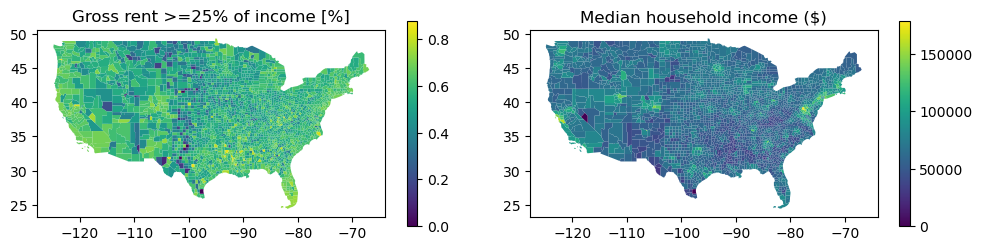

In [ ]:
plotables = gdf.columns.difference(["geometry", "GEOIDFQ"])[:10]
fig, ax = plt.subplots(48, 2, figsize=(10, 120))
ax = ax.flatten()
plt.tight_layout()

for i, column in enumerate(plotables):
    gdf.plot(column=column, ax=ax[i], cmap='viridis', legend=True)
    ax[i].set_title(column)

for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

* Easter Egg

In [122]:
print(chr(sum(range(ord(min(str(not())))))))

ඞ
